In [77]:
from diffusers import DiffusionPipeline
from PIL import Image
import logging
import numpy as np
from python_coreml_stable_diffusion.pipeline import get_coreml_pipe
from diffusers import StableDiffusionPipeline
import pylrc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import re
from PIL import ImageDraw, ImageFont
import os
import imageio
import datetime
import math
from IPython.display import Video
import openai
import requests
from tqdm import tqdm
import uuid
from concurrent.futures import ThreadPoolExecutor, as_completed

In [47]:
# CONSTANTS

# Stable Diffusion
seed = 93
model_version = "runwayml/stable-diffusion-v1-5"
i = "stable_diffusion_apple/models/coreml-stable-diffusion-v1-5_split_einsum_packages"
compute_unit = "ALL"
num_inference_steps = 20
guidance_scale = 7.5

# Music
local_image_generation = False
fps = 30
lyrics_filename = "Mr_Blue_Sky.lrc"
# Use None if you want to generate the prompts automatically
image_prompts_filename = None #"yesterday_prompts.txt"
song_title = "Mr. Blue Sky"
audio_filename = "Mr_Blue_Sky.mp3"
output_filename_no_audio = "outputs/Mr_Blue_Sky_music_video_no_audio.mp4"
output_filename = "outputs/Mr_Blue_Sky_music_video.mp4"

In [117]:
# Boilerplate diffuser code for running the original SD model on m1 mac (https://huggingface.co/docs/diffusers/optimization/mps)
# pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
# pipe = pipe.to("mps")

# # Recommended if your computer has < 64 GB of RAM
# pipe.enable_attention_slicing()

# prompt = "a photo of an astronaut riding a horse on mars"

# # First-time "warmup" pass if PyTorch version is 1.13 (see explanation above)
# # _ = pipe(prompt, num_inference_steps=1)

# # Results match those from the CPU device after the warmup pass.
# image = pipe(prompt, num_inference_steps=20).images[0]

# # Convert the numpy array to an Image object
# img = Image.fromarray(image)

# # Show the image
# img.show()

In [58]:
def get_model(
    model_version, i, compute_unit, prompt, num_inference_steps, guidance_scale
):
    logger.info("Initializing PyTorch pipe for reference configuration")

    pytorch_pipe = StableDiffusionPipeline.from_pretrained(
        model_version, use_auth_token=True
    )

    user_specified_scheduler = None
    # if args.scheduler is not None:
    #     user_specified_scheduler = SCHEDULER_MAP[args.scheduler].from_config(
    #         pytorch_pipe.scheduler.config
    #     )

    # Use the coreml model for efficiency on m1 mac
    coreml_pipe = get_coreml_pipe(
        pytorch_pipe=pytorch_pipe,
        mlpackages_dir=i,
        model_version=model_version,
        compute_unit=compute_unit,
        scheduler_override=user_specified_scheduler,
    )

    return coreml_pipe

In [59]:
def generate_image(model, prompt, neg_prompt, num_inference_steps, guidance_scale):
    logger.info("Beginning image generation.")
    image = model(
        prompt=prompt,
        negative_prompt=neg_prompt,
        height=model.height,
        width=model.width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
    )
    
    return image
    #logger.info(f"Saving generated image to {out_path}")
    #image["images"][0].save(out_path)

In [8]:
def init(seed):
    # TODO: Figure out how to make the results deterministic
    logger.info(f"Setting random seed to {seed}")
    np.random.seed(seed)

In [9]:
# Init logging
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

init(seed)

INFO:__main__:Setting random seed to 93


In [10]:
if local_image_generation:
    # Initializing the coreml model is unfortunately very slow
    model = get_model(
        model_version, i, compute_unit, prompt, num_inference_steps, guidance_scale
    )

In [11]:
if local_image_generation:
    # Test that the model is working
    prompt = "a photo of an astronaut riding a horse on mars"
    neg_prompt = ""
    image = generate_image(model, prompt, neg_prompt, num_inference_steps, guidance_scale)

In [12]:
if local_image_generation:
    image["images"][0]

In [13]:
lrc_file = open(lyrics_filename)
lrc_string = ''.join(lrc_file.readlines())
lrc_file.close()

subs = pylrc.parse(lrc_string)

In [66]:
def get_prompts(iterator):
    prompts = []
    for line in iterator:
        prompts.append
        match = re.search(r'\d+\.\s+(.+)', line)
        assert match
        if match:
            words = match.group(1)
            prompts.append(words)
    return prompts

if image_prompts_filename is not None:
    prompts_file = open(image_prompts_filename)
    iterator = prompts_file.readlines()
    prompts = get_prompts(iterator)
    prompts_file.close()
else:
    # Generate prompts for the lyrics using the OpenAI api
    lyrics_string = "".join([f"{str(j+1)}. {sub.text}\n" for j, sub in enumerate(subs)])

    openai.api_key = os.getenv("OPENAI_API_KEY")
    prompt = f'I want to create a sequence of images for the song {song_title}. ' \
             'I will provide the lyrics to you, and want you to give one prompt for each image' \
             ' that can be given to a generative image model. Output ONLY the prompts as a ' \
             'numbered list (using the same numbers as the lyric list) formatted like ' \
             '"1. [prompt 1]\n 2. [prompt 2]\n...". For each prompt use this template as a guideline: ' \
             '"[format] of [subject term], a [solidifier], [perspective], by [artist] in the style of ' \
             '[style], [vibe], [booster]. Here is an example which follows this template: ' \
             '"oil painting of a space whale, a whale in space, through a porthole, by alphonse mucha in ' \
             'the style of control the soul, trending on artstation, beautiful, otherworldly". Use evocative artistic language and formats' \
             ' (i.e. things like oil paintings, sketches, sculptures rather than photographs). Here are some more good example' \
             ' prompts for inspiration:\n' \
             '- a portrait of an old coal miner in 19th century, beautiful painting with highly detailed face by greg rutkowski and magali villanueve\n' \
             '- store full of curious collectibles :: incredible, anime, Digital 2D, animated by Kyoto Animation, Studio Ghibli, Miyazaki, AKIRA art style, beautiful, gorgeous, dramatic lighting, rule of thirds, perfect composition, trending on ArtStation, 4k\n' \
             '- landscape of english countryside, coloring book, black and white, stars, black sky, clean lines, detailed, magical, van gogh style, wavy pattern\n\n' \
             f'Here are the {len(subs)} lyrics:\n'
    prompt += f'{lyrics_string}'
    
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[         
         {"role": "user", "content": prompt}
      ],
      temperature=0.7,
      max_tokens=2 * len(lyrics_string),
      top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=0.0
    )
    print(prompt)
    print(response)
    prompts = response["choices"][0]["message"]["content"]
    iterator = list(filter(lambda p: len(p) > 0, prompts.splitlines()))
    prompts = get_prompts(iterator)
    

print(prompts)
assert len(prompts) == len(subs)

I want to create a sequence of images for the song Mr. Blue Sky. I will provide the lyrics to you, and want you to give one prompt for each image that can be given to a generative image model. Output ONLY the prompts as a numbered list (using the same numbers as the lyric list) formatted like "1. [prompt 1]
 2. [prompt 2]
...". For each prompt use this template as a guideline: "[format] of [subject term], a [solidifier], [perspective], by [artist] in the style of [style], [vibe], [booster]. Here is an example which follows this template: "oil painting of a space whale, a whale in space, through a porthole, by alphonse mucha in the style of control the soul, trending on artstation, beautiful, otherworldly". Use evocative artistic language and formats (i.e. things like oil paintings, sketches, sculptures rather than photographs). Here are some more good example prompts for inspiration:
- a portrait of an old coal miner in 19th century, beautiful painting with highly detailed face by greg

In [67]:
# Save the prompts
with open(f"outputs/{song_title}_prompts.txt", 'w') as out:
    out.write("\n".join([f'{str(idx + 1)}. {p}' for idx, p in enumerate(prompts)]) + '\n')

In [68]:
song_images = []
local_image_generation = False

if local_image_generation:
    for j, sub in enumerate(tqdm(subs)):
        text = sub.text
        time = sub.time
        prompt = prompts[j]
        neg_prompt = "text, words"
        images = generate_image(model, prompt, neg_prompt, num_inference_steps, guidance_scale)
        image = images["images"][0]
            
    song_images.append(image)
else:
    # Query the generative AI art api concurrently using multiple threads
    def generate_img(idx, prompt):
        try:
            response = openai.Image.create(
                  prompt=prompt,
                  n=1,
                  size="512x512"
            )
            image_url = response['data'][0]['url']
            image = Image.open(requests.get(image_url, stream=True).raw)
            
            return idx, image
        except requests.exceptions.RequestException as e:
            return e
 
    def runner():
        threads= []
        results = {}
        
        with tqdm(total=len(prompts)) as pbar:
            with ThreadPoolExecutor(max_workers=40) as executor:
                for idx, prompt in enumerate(prompts):
                    threads.append(executor.submit(generate_img, idx, prompt))

                for task in as_completed(threads):
                    idx, image = task.result()
                    results[idx] = image
                    pbar.update(1)
        
        results_sorted = []
        for key, value in sorted(results.items()):
            results_sorted.append(value)

        return results_sorted

       
    song_images = runner()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:12<00:00,  3.24it/s]


In [142]:
# Save the results
for idx, img in enumerate(song_images):
    img.save(f"outputs/{song_title}_img_{idx + 1}.png", "PNG")

In [133]:
#plt.figure(figsize=(100,100))
#columns = 1

song_images_with_lyrics = list(map(lambda img: img.copy(), song_images))


def get_wrapped_text(text: str, font: ImageFont.ImageFont,
                     line_length: int):
        """From: https://stackoverflow.com/a/67203353"""
        final_lines = []
        for orig_line in text.splitlines():
            cur_lines = ['']
            for word in orig_line.split():
                line = f'{cur_lines[-1]} {word}'.strip()
                if font.getlength(line) <= line_length:
                    cur_lines[-1] = line
                else:
                    cur_lines.append(word)
                    
            final_lines.append('\n'.join(cur_lines))
        return '\n'.join(final_lines)
    
def add_subtitle(
    bg,
    text="nice",
    xy=("center", 370),
    font="Arial",
    font_size=18,
    font_color=(255, 255, 255),
    stroke=2,
    stroke_color=(0, 0, 0),
    shadow=None,
    shadow_color=(0, 0, 0),
):
    """draw subtitle on image by pillow
    From: https://stackoverflow.com/a/62731552
    Args:
        bg(PIL image): image to add subtitle
        text(str): subtitle
        xy(tuple): absolute top left location of subtitle
        ...: extra style of subtitle
    Returns:
        bg(PIL image): image with subtitle
    """
    stroke_width = stroke
    xy = list(xy)
    W, H = bg.width, bg.height
    font = ImageFont.truetype(str(font), font_size)
    draw = ImageDraw.Draw(bg)
    text = get_wrapped_text(text, font, int(W * 0.9))
    left, top, right, bottom = draw.multiline_textbbox((0, 0), text, font=font, align="center", stroke_width=stroke_width)
    #print(left, top, right, bottom)
    w = right - left
    h = bottom - top
    if xy[0] == "center":
        xy[0] = (W - w) // 2
        #print(W, w, xy[0], left, right)
    if xy[1] == "center":
        xy[1] = (H - h) // 2
    if shadow:
        draw.text(
            (xy[0] + shadow[0], xy[1] + shadow[1]), text, font=font, fill=shadow_color, align="center"
        )
    draw.text(
        (xy[0], xy[1]),
        text,
        font=font,
        fill=font_color,
        stroke_width=stroke_width,
        stroke_fill=stroke_color,
        align="center"
    )
    return bg

for j, image in enumerate(song_images_with_lyrics):
    #plt.subplot(len(subs) // columns + 1, columns, j + 1)
    #plt.axis('off')
    #plt.title(sub.text + "(prompt: {})".format(prompt))
    #x = 30
    #y = 400
    #plt.text(x, y, subs[j].text, color="white", bbox=dict(fill=True, facecolor="black"))
    #plt.imshow(image)
    
    text = "Lyric: " + subs[j].text + "\nPrompt: " + prompts[j]#get_wrapped_text(prompts[j], font, 420)
    add_subtitle(image, text=text)
    
    """draw = ImageDraw.Draw(image)
    
    
    _, _, w, h = draw.multiline_textbbox((0, 0), text, font=font, align="center")
    left = (512 - w) // 2
    top = 400
    right = left + w
    bottom = top + h
    draw.rectangle((left, top, right, bottom), fill=(0, 0, 0), outline=None, width=2)
    draw.text(
    (left, top),  # Coordinates
    text,  # Text
    (255, 255, 255),  # Color
    font=font,
    align="center"
    )"""

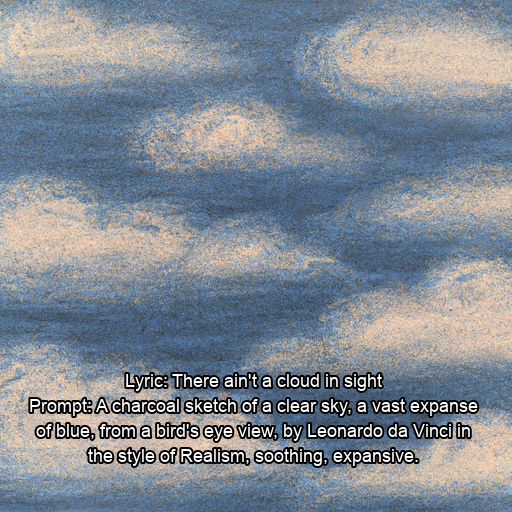

In [134]:
song_images_with_lyrics[1]

In [134]:
"""plt.figure(figsize=(60,30))
columns = 1

for j in range(len(song_images)):
    plt.subplot(len(subs) // columns + 1, columns, j + 1)
    plt.axis('off')
    plt.title(subs[j].text)
    plt.imshow(song_images[j])

plt.tight_layout()"""

"plt.figure(figsize=(60,30))\ncolumns = 1\n\nfor j in range(len(song_images)):\n    plt.subplot(len(subs) // columns + 1, columns, j + 1)\n    plt.axis('off')\n    plt.title(subs[j].text)\n    plt.imshow(song_images[j])\n\nplt.tight_layout()"

In [135]:
subs.length

'05:02.11'

In [136]:
x = datetime.datetime.strptime(subs.length, '%M:%S.%f')
song_minutes, song_seconds, song_milliseconds = x.minute, x.second, x.microsecond / 1000
song_length_milliseconds = song_minutes * 60000 + song_seconds * 1000 + song_milliseconds
song_length_milliseconds

302110.0

In [137]:
total_frames = fps * math.ceil(song_length_milliseconds / 1000)
#print(total_frames)

# Create an imageio writer object with the specified fps and output format
writer = imageio.get_writer(output_filename_no_audio, fps=fps)

def get_timestep_from_sub(sub):
    # Return the timestep in milliseconds
    return sub.minutes * 60000 + sub.seconds * 1000 + sub.milliseconds

image_idx = 0
next_image_timestep_milliseconds = get_timestep_from_sub(subs[image_idx])

title_image = Image.new('RGB', (512, 512))
add_subtitle(title_image, song_title, font_size=32, xy=("center", "center"))

image_list = [title_image] + song_images_with_lyrics
for j in range(total_frames):
    timestep_milliseconds = j / fps * 1000
    #print(j, timestep_milliseconds, next_image_timestep_milliseconds)
    if timestep_milliseconds >= next_image_timestep_milliseconds:
        image_idx += 1
        if image_idx < len(song_images_with_lyrics):
            next_image_timestep_milliseconds = get_timestep_from_sub(subs[image_idx])
        else:
            # Keep using this image until the end
            next_image_timestep_milliseconds = math.inf
            
    #print(j, image_idx)
    np_image = np.array(image_list[image_idx])

    writer.append_data(np_image)
    
# Close the writer object to finalize the output file
writer.close()

In [140]:
def add_audio_to_video(video_file, audio_file, output_file):
    # Combine the audio and video. The audio needs to be transcoded so that -shortest does not result in silence at the end
    os.system(f"ffmpeg -i {video_file} -i {audio_file} -shortest -c:v copy -c:a aac -map 0:v:0 -map 1:a:0  {output_file}")

add_audio_to_video(output_filename_no_audio, audio_filename, output_filename)

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

In [141]:
Video(filename=output_filename)